# Soma detection notebook

This notebook demonstrates how to use `brainlit.algorithms.detect_somas.find_somas` to detect bright somas in brain volumes of $100\mu m^3$.

In [1]:
import boto3
import numpy as np
from io import BytesIO
from cloudvolume.lib import Bbox
from brainlit.utils.session import NeuroglancerSession
from brainlit.algorithms.detect_somas import find_somas
import matplotlib.pyplot as plt

brain = 1
mip = 1

/Users/jacopo/opt/miniconda3/envs/brainlit/lib/python3.8/site-packages/python_jsonschema_objects/__init__.py:50: UserWarning: Schema version http://json-schema.org/draft-04/schema not recognized. Some keywords and features may not be supported.
  warnings.warn(


In [2]:
s3 = boto3.resource("s3")
bucket = s3.Bucket("open-neurodata")

brain_name = f"brain{brain}"

brain_prefix = f"brainlit/{brain_name}"
segments_prefix = f"brainlit/{brain_name}_segments"
somas_prefix = f"brainlit/{brain_name}_somas"

brain_url = f"s3://open-neurodata/{brain_prefix}"
segments_url = f"s3://open-neurodata/{segments_prefix}"

volume_keys = [
    "4807349.0_3827990.0_2922565.75_4907349.0_3927990.0_3022565.75",
    "4873075.5_4753413.5_6851474.0_4973075.5_4853413.5_6951474.0",
    "4881146.0_4792378.5_7001708.5_4981146.0_4892378.5_7101708.5"
]

ngl_sess = NeuroglancerSession(
    mip=mip, url=brain_url, url_segments=segments_url, use_https=True
)
res = ngl_sess.cv_segments.scales[ngl_sess.mip]["resolution"]

Downloading:   0%|          | 0/18 [00:01<?, ?it/s]


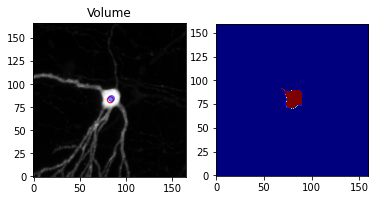

Downloading:   0%|          | 0/12 [00:04<?, ?it/s]


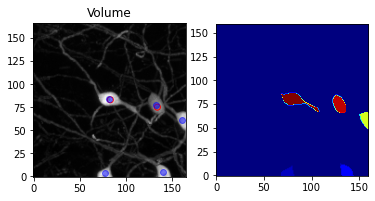

Downloading:   0%|          | 0/18 [00:02<?, ?it/s]


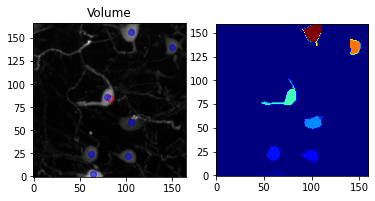

In [3]:
for volume_key in volume_keys:
    volume_coords = np.array(
        os.path.basename(volume_key).split("_")
    ).astype(float)
    volume_vox_min = np.round(np.divide(volume_coords[:3], res)).astype(int)
    volume_vox_max = np.round(np.divide(volume_coords[3:], res)).astype(int)

    bbox = Bbox(volume_vox_min, volume_vox_max)
    volume = ngl_sess.pull_bounds_img(bbox)

    somas_obj = s3.Object("open-neurodata", f"{somas_prefix}/{volume_key}").get()
    somas = np.load(BytesIO(somas_obj["Body"].read()))
    rel_soma_coords = np.array(
        [
            np.round(np.divide(c, res)).astype(int) - volume_vox_min
            for c in somas
        ]
    )

    label, rel_pred_centroids, out = find_somas(volume, res)

    _, axes = plt.subplots(1, 2)

    ax = axes[0]
    vol_proj = np.amax(volume, axis=2)
    ax.imshow(vol_proj, cmap="gray", origin="lower")
    ax.scatter(rel_soma_coords[:, 1], rel_soma_coords[:, 0], c="none", edgecolor="r", label="Ground truth")
    if label == 1:
        ax.scatter(rel_pred_centroids[:, 1], rel_pred_centroids[:, 0], c="b", alpha=0.5)
    ax.set_title("Volume")

    ax = axes[1]
    mask_proj = np.amax(out, axis=2)
    ax.imshow(mask_proj, cmap="jet", vmin=0, origin="lower")
    plt.show()